<a href="https://colab.research.google.com/github/hhur0104/hh_adv_methods_project/blob/main/Data71200_HH_Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [152]:
import os
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt 


!pip install mglearn
import mglearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Step 1. Preping the Data

In [205]:
# Loading data
# Original data source (Kaggle): https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download
stroke = pd.read_csv("https://raw.githubusercontent.com/hhur0104/hh_adv_methods_project/main/healthcare-dataset-stroke-data.csv")
stroke.head()

# Get rid of some data 
stroke = stroke.drop(stroke[stroke['age'] <= 30].index)

# Encode categoricals
stroke_en = pd.get_dummies(stroke)
print(stroke_en.columns)

# Handle missing data
stroke_cln = stroke_en[~stroke_en['bmi'].isna()]
print("Before: ", stroke_en.shape)
print("After: ",stroke_cln.shape)
# Input features
X = stroke_cln.drop(["id","stroke"], axis=1)
# Label 
y = stroke_cln["stroke"]

X = X[['age','bmi','hypertension','heart_disease']]
print("X shape: ", X.shape)
print("y shape: ", y.shape)

Index(['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'stroke', 'gender_Female', 'gender_Male', 'ever_married_No',
       'ever_married_Yes', 'work_type_Govt_job', 'work_type_Private',
       'work_type_Self-employed', 'Residence_type_Rural',
       'Residence_type_Urban', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes'],
      dtype='object')
Before:  (3540, 20)
After:  (3373, 20)
X shape:  (3373, 4)
y shape:  (3373,)


## Step 2. PCA with scaled data

In [206]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

# Scale data
scaler = StandardScaler()
scaler.fit(X)
X_sc = scaler.transform(X)


# Split data
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X_sc, y):
    X_train = X_sc[train_index]
    X_test = X_sc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

([<matplotlib.axis.XTick at 0x7fa6ed9aa850>,
 [Text(0, 1, 'age'),
  Text(0, 1, 'bmi'),
  Text(0, 1, 'hypertension'),
  Text(0, 1, 'heart_disease')])

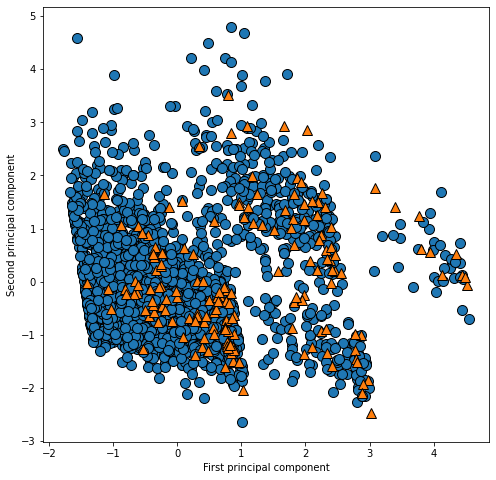

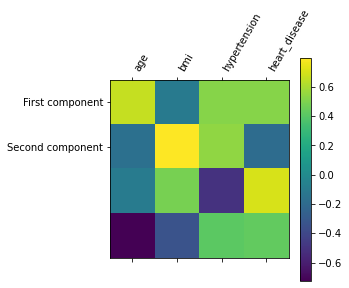

In [155]:
from sklearn.decomposition import PCA

# keep the first two principal components of the data
pca = PCA(n_components=0.95)
# fit PCA model to data
pca.fit(X_train)

# transform data onto the first two principal components
X_pca = pca.transform(X_train)
#print(X_pca2)

# plot first vs. second principal component, colored by class
plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], y_train)

plt.xlabel("First principal component")
plt.ylabel("Second principal component")

# pca.components_ how many features?
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(X.columns)),
           X.columns, rotation=60, ha='left')

## Step 2. PCA with unscaled data

In [207]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler


# Split data
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, y):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

([<matplotlib.axis.XTick at 0x7fa6ea7019d0>,
 [Text(0, 1, 'age'),
  Text(0, 1, 'bmi'),
  Text(0, 1, 'hypertension'),
  Text(0, 1, 'heart_disease')])

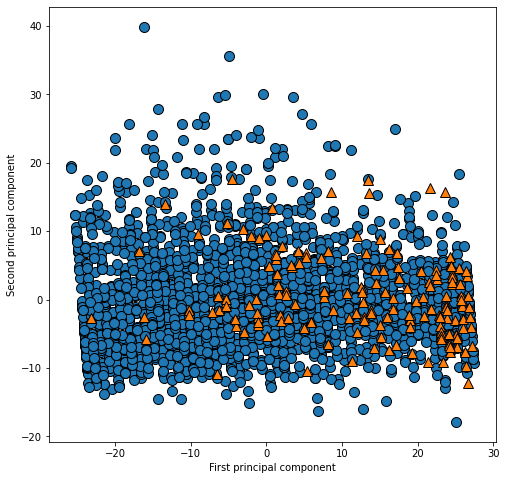

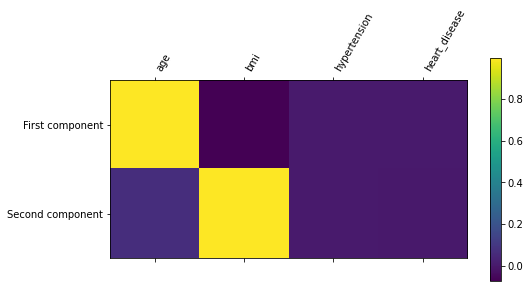

In [208]:
from sklearn.decomposition import PCA
# keep the first two principal components of the data
pca = PCA(n_components=0.95)
# fit PCA model to data
pca.fit(X_train)

# transform data onto the first two principal components
X_pca = pca.transform(X_train)


# plot first vs. second principal component, colored by class
plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], y_train)

plt.xlabel("First principal component")
plt.ylabel("Second principal component")

# pca.components_ how many features?
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(X.columns)),
           X.columns, rotation=60, ha='left')

I tried both scaled and unscaled version of the data for PCA. When unscaled, scatter plots shows some seperation among first component among dataset. While samples with label 0 is spread out everywhere, most of the '1' samples are apparent on the right side. However, this seperation does not seem to seperate the classses.

It looks age, bmi and avg_glucose_level are the variables that have some importance in predicting the data. Though in the scatter plot, it doesn't look that two classes are really differentiable. I suspect this might because of imbalance in the data.

Time to see if the PCA transformation helps the accuracy of the model. I use unscaled version to make comparison with project 2 outcome which used unscaled data. 

In [210]:
# Spliting data using X_pca
for train_index, test_index in split.split(X_pca, y_train):
    X2_train = X_pca[train_index]
    X2_test = X_pca[test_index]
    y2_train = y_train.iloc[train_index]
    y2_test = y_train.iloc[test_index]

# RandomForest with GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

forest_gs = RandomForestClassifier(random_state=1, n_estimators=5)
forest_gs.fit(X2_train, y2_train)
y_pred_gs = forest_gs.predict(X2_test)

print("Number of 0: ", list(y_pred_gs).count(0))
print("Number of 1: ", list(y_pred_gs).count(1))
print(y_pred_gs)
print(classification_report(y2_test, y_pred_gs))

print("Test set R^2: {:.2f}".format(forest_gs.score(X2_test, y2_test)))
print("Test set RMSE: {:.2f}".format(mean_squared_error(y2_test, y_pred_gs)))
print("Test set MSE: {:.2f}".format(mean_absolute_error(y2_test, y_pred_gs)))

Number of 0:  509
Number of 1:  31
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 

The metrics are slightly worse than the random forest model used without the PCA transformation in project 2.

## Step 3.1.1 K-means on the data without PCA transformation

Text(0, 0.5, 'Feature 1: Bmi')

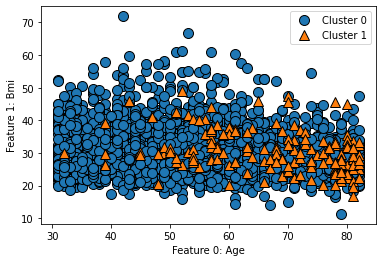

In [159]:
mglearn.discrete_scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], y_train)
plt.legend(["Cluster 0", "Cluster 1"], loc="best")
plt.xlabel("Feature 0: Age")
plt.ylabel("Feature 1: Bmi")

[1 1 0 ... 1 1 0]


Text(0, 0.5, 'Feature 1: Bmi')

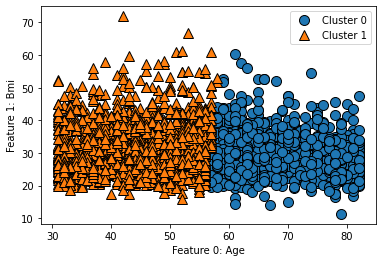

In [160]:
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cluster import KMeans


# build the clustering model
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_train)
assignments=kmeans.labels_
print(assignments)

mglearn.discrete_scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], assignments)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0: Age")
plt.ylabel("Feature 1: Bmi")


## Step 3.1.2 K-means on the data with PCA transformation

Text(0, 0.5, 'Feature 1: Bmi')

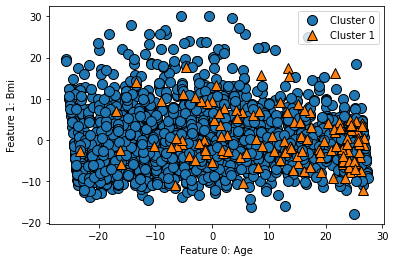

In [161]:
mglearn.discrete_scatter(X2_train[:, 0], X2_train[:, 1], y2_train)
plt.legend(["Cluster 0", "Cluster 1"], loc="best")
plt.xlabel("Feature 0: Age")
plt.ylabel("Feature 1: Bmi")

[0 0 0 ... 1 1 1]


Text(0, 0.5, 'Feature 1: Bmi')

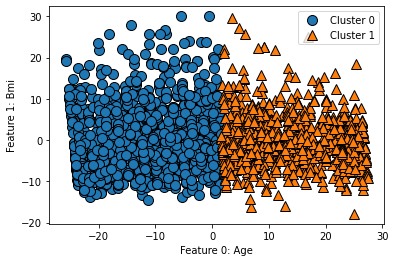

In [176]:
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cluster import KMeans


# build the clustering model
kmeans = KMeans(n_clusters=2)
kmeans.fit(X2_train)
assignments=kmeans.labels_
print(assignments)

mglearn.discrete_scatter(X2_train[:, 0], X2_train[:, 1], assignments)
plt.legend(["Cluster 0", "Cluster 1"], loc="best")
plt.xlabel("Feature 0: Age")
plt.ylabel("Feature 1: Bmi")


## Step 3.2.1 Agglomerative/Hierarchical on the data without PCA transformation

Text(0, 0.5, 'Feature 1: Bmi')

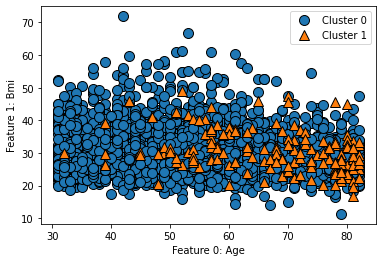

In [163]:
mglearn.discrete_scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], y_train)
plt.legend(["Cluster 0", "Cluster 1"], loc="best")
plt.xlabel("Feature 0: Age")
plt.ylabel("Feature 1: Bmi")

Text(0, 0.5, 'Feature 1')

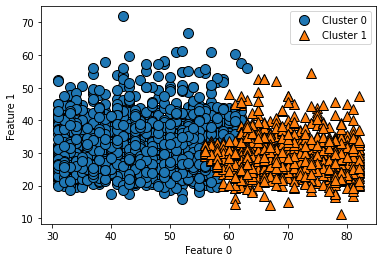

In [164]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=2)
assignment = agg.fit_predict(X_train)

mglearn.discrete_scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], assignment)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Text(0, 0.5, 'Cluster distance')

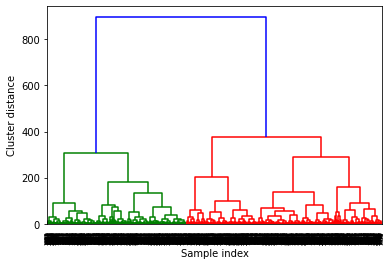

In [165]:
# Import the dendrogram function and the ward clustering function from SciPy
from scipy.cluster.hierarchy import dendrogram, ward

# Apply the ward clustering to the data array X
# The SciPy ward function returns an array that specifies the distances
# bridged when performing agglomerative clustering
linkage_array = ward(X_train)
# Now we plot the dendrogram for the linkage_array containing the distances
# between clusters
dendrogram(linkage_array)

# mark the cuts in the tree that signify two or three clusters

plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

## Step 3.2.2 Agglomerative/Hierarchical on the data with PCA transformation

Text(0, 0.5, 'Feature 1: Bmi')

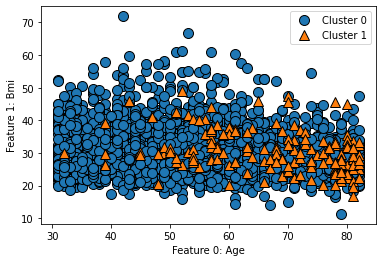

In [166]:
# With the actual labels
mglearn.discrete_scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], y_train)
plt.legend(["Cluster 0", "Cluster 1"], loc="best")
plt.xlabel("Feature 0: Age")
plt.ylabel("Feature 1: Bmi")

Text(0, 0.5, 'Feature 1')

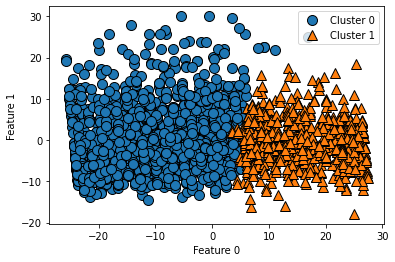

In [211]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=2)
assignment = agg.fit_predict(X2_train)

mglearn.discrete_scatter(X2_train[:, 0], X2_train[:, 1], assignment)
plt.legend(["Cluster 0", "Cluster 1"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

Text(0, 0.5, 'Cluster distance')

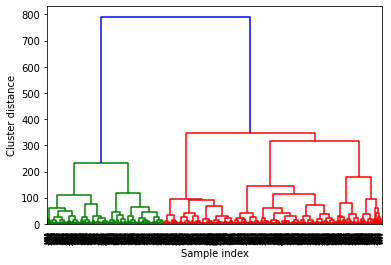

In [168]:
# Import the dendrogram function and the ward clustering function from SciPy
from scipy.cluster.hierarchy import dendrogram, ward

# Apply the ward clustering to the data array X
# The SciPy ward function returns an array that specifies the distances
# bridged when performing agglomerative clustering
linkage_array = ward(X2_train)
# Now we plot the dendrogram for the linkage_array containing the distances
# between clusters
dendrogram(linkage_array)

# mark the cuts in the tree that signify two or three clusters

plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

## 3.3.1. DBSCAN with on the data without the PCA transformation

In [169]:
from sklearn.cluster import DBSCAN
from collections import Counter

dbscan = DBSCAN(min_samples=2,eps=0.5)
clusters = dbscan.fit_predict(X_train)
#print(Counter(clusters))
#print(X_train.shape)
#print(len(clusters))

IndexError: ignored

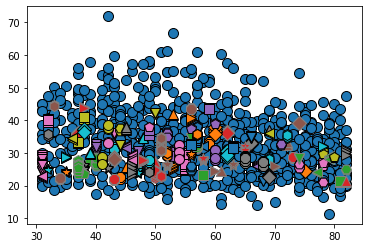

In [170]:
mglearn.discrete_scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], clusters)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"], loc="best")
plt.xlabel("Feature 0: Age")
plt.ylabel("Feature 1: Bmi")

Text(0, 0.5, 'Feature 1: Bmi scaled')

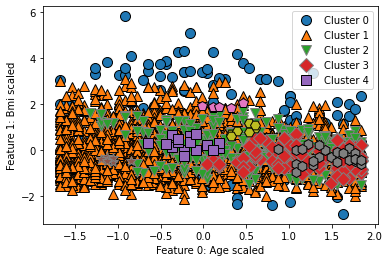

In [171]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)

dbscan = DBSCAN(min_samples=5,eps=0.3)
clusters = dbscan.fit_predict(X_scaled)

# Plot clusters
mglearn.discrete_scatter(X_scaled[:, 0], X_scaled[:, 1], clusters)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"], loc="best")
plt.xlabel("Feature 0: Age scaled")
plt.ylabel("Feature 1: Bmi scaled")

## 3.3.2. DBSCAN with on the data with the PCA transformation

Since the data is went through transformation I am skipping the scaling in this trial.

Counter({-1: 419, 2: 31, 48: 28, 109: 18, 31: 15, 82: 15, 94: 15, 155: 15, 55: 14, 0: 13, 86: 13, 124: 13, 158: 12, 24: 11, 102: 11, 17: 10, 69: 10, 152: 10, 229: 10, 241: 10, 16: 9, 33: 9, 99: 9, 117: 9, 137: 9, 141: 9, 353: 9, 11: 8, 38: 8, 80: 8, 89: 8, 113: 8, 121: 8, 129: 8, 169: 8, 233: 8, 244: 8, 257: 8, 7: 7, 19: 7, 59: 7, 62: 7, 83: 7, 92: 7, 96: 7, 118: 7, 134: 7, 146: 7, 176: 7, 206: 7, 267: 7, 269: 7, 354: 7, 373: 7, 4: 6, 39: 6, 46: 6, 57: 6, 68: 6, 72: 6, 95: 6, 108: 6, 128: 6, 142: 6, 149: 6, 168: 6, 186: 6, 194: 6, 198: 6, 210: 6, 216: 6, 223: 6, 230: 6, 246: 6, 289: 6, 309: 6, 313: 6, 329: 6, 345: 6, 1: 5, 8: 5, 44: 5, 49: 5, 58: 5, 60: 5, 74: 5, 79: 5, 85: 5, 91: 5, 100: 5, 101: 5, 151: 5, 154: 5, 161: 5, 162: 5, 163: 5, 181: 5, 184: 5, 188: 5, 191: 5, 197: 5, 208: 5, 209: 5, 224: 5, 245: 5, 249: 5, 272: 5, 276: 5, 284: 5, 299: 5, 304: 5, 374: 5, 401: 5, 426: 5, 5: 4, 6: 4, 9: 4, 12: 4, 14: 4, 21: 4, 22: 4, 30: 4, 36: 4, 41: 4, 42: 4, 43: 4, 56: 4, 65: 4, 66: 4, 73: 4

IndexError: ignored

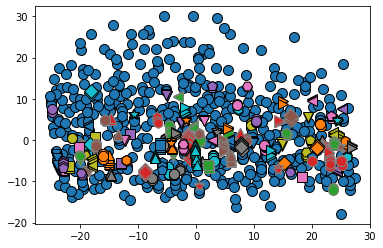

In [177]:
from sklearn.cluster import DBSCAN
from collections import Counter

dbscan = DBSCAN(min_samples=2,eps=0.5)
clusters = dbscan.fit_predict(X2_train)
print(Counter(clusters))
print(X2_train.shape)
print(len(clusters))

# Some unknown error is presisting...
mglearn.discrete_scatter(X2_train[:, 0], X2_train[:, 1], clusters)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"], loc="best")
plt.xlabel("Feature 0: Age")
plt.ylabel("Feature 1: Bmi")

## Step 3.4. ARI & Silhouette Coefficient for no PCA transformed data





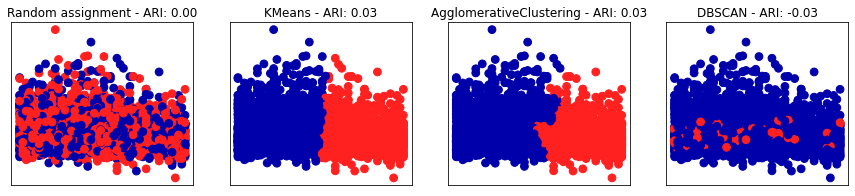

In [174]:
from sklearn.metrics.cluster import adjusted_rand_score

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# make a list of algorithms to use
algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2),
              DBSCAN()]

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X_train))

# plot random assignment
axes[0].scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=random_clusters,
                cmap=mglearn.cm2, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(
        adjusted_rand_score(y_train, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    # plot the cluster assignments and cluster centers
    clusters = algorithm.fit_predict(X_train)
    ax.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=clusters,
               cmap=mglearn.cm2, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__,
                                           adjusted_rand_score(y_train, clusters)))

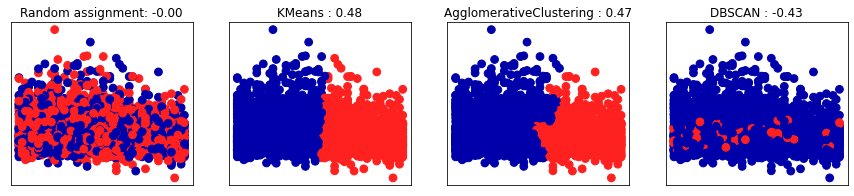

In [180]:
from sklearn.metrics.cluster import silhouette_score


fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X_train))

# plot random assignment
axes[0].scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=random_clusters,
                cmap=mglearn.cm2, s=60)
axes[0].set_title("Random assignment: {:.2f}".format(
    silhouette_score(X_train, random_clusters)))

algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2),
              DBSCAN()]

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_train)
    # plot the cluster assignments and cluster centers
    ax.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=clusters, cmap=mglearn.cm2,
               s=60)
    ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__,
                                      silhouette_score(X_train, clusters)))

## Step 3.4. ARI & Silhouette Coefficient for PCA transformed data

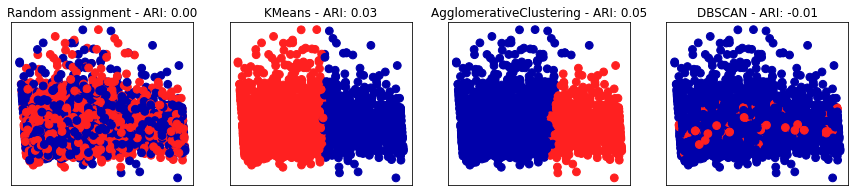

In [181]:
from sklearn.metrics.cluster import adjusted_rand_score

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# make a list of algorithms to use
algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2),
              DBSCAN()]

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X2_train))

# plot random assignment
axes[0].scatter(X2_train[:, 0], X2_train[:, 1], c=random_clusters,
                cmap=mglearn.cm2, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(
        adjusted_rand_score(y2_train, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    # plot the cluster assignments and cluster centers
    clusters = algorithm.fit_predict(X2_train)
    ax.scatter(X2_train[:, 0], X2_train[:, 1], c=clusters,
               cmap=mglearn.cm2, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__,
                                           adjusted_rand_score(y2_train, clusters)))

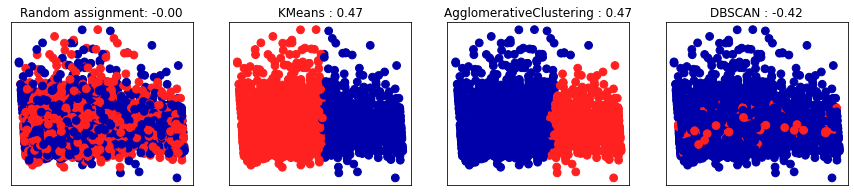

In [182]:
from sklearn.metrics.cluster import silhouette_score


fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X2_train))


# plot random assignment
axes[0].scatter(X2_train[:, 0], X2_train[:, 1], c=random_clusters,
                cmap=mglearn.cm2, s=60)
axes[0].set_title("Random assignment: {:.2f}".format(
    silhouette_score(X2_train, random_clusters)))

algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2),
              DBSCAN()]

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X2_train)
    # plot the cluster assignments and cluster centers
    ax.scatter(X2_train[:, 0], X2_train[:, 1], c=clusters, cmap=mglearn.cm2,
               s=60)
    ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__,
                                      silhouette_score(X2_train, clusters)))

## Step 3 Summary

As seen in the plots, I couldn't get any meaningful results from the clusters. Since this problem is a binary classficiation problem and the dataset is heavily imbalanced, most of the data points should be in one cluster and only marginal percentage of the points should belong to the other cluster. But the plots all indicate other wise except for the DBSCAN plot with pca transformed data. 

So the following is the second attempt on utilizing these algorithms to produce meaningful result with breast cancer dataset from scikit-learn.

## Step 4. With Breast Cancer Data



Load data and split them, one with PCA transformation and the other without the transformation.

In [183]:
from sklearn.datasets import load_breast_cancer

bcd = load_breast_cancer()
scaler = StandardScaler()
scaler.fit(bcd.data)

bcd_scaled = scaler.transform(bcd.data)

In [ ]:
print(bcd.DESCR)
print(bcd.feature_names)

In [185]:
# Split the data without PCA transformation
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(bcd_scaled, bcd.target):
    X_train = bcd_scaled[train_index]
    X_test = bcd_scaled[test_index]
    y_train = bcd.target[train_index]
    y_test = bcd.target[test_index]

In [186]:
pca95 = PCA(n_components=0.95)
# fit PCA model to data
pca95.fit(bcd_scaled)
# transform data onto the first ten principal components
X_pca = pca95.transform(bcd_scaled)

for train_index, test_index in split.split(X_pca, bcd.target):
    X2_train = X_pca[train_index]
    X2_test = X_pca[test_index]
    y2_train = bcd.target[train_index]
    y2_test = bcd.target[test_index]

Text(0, 0.5, 'Principal components')

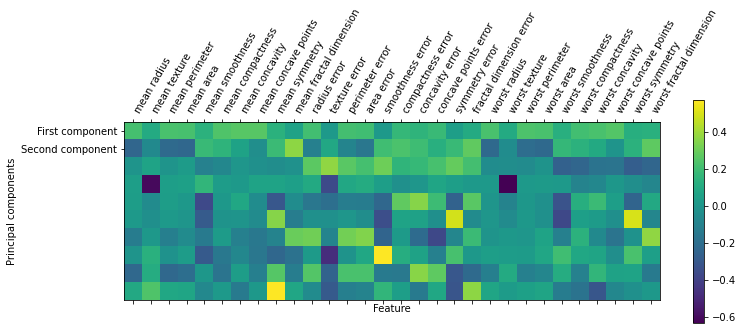

In [187]:
plt.matshow(pca95.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(bcd.feature_names)),
           bcd.feature_names, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")

Text(0.5, 1.0, 'ScatterPlot with the actual labels')

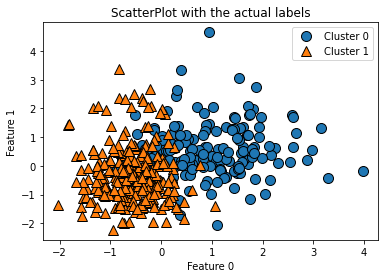

In [188]:
# With the actual labels
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)
plt.legend(["Cluster 0", "Cluster 1"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title("ScatterPlot with the actual labels")

Text(0.5, 1.0, 'ScatterPlot with the actual labels. PCA transformation')

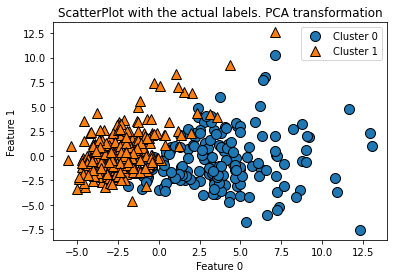

In [189]:
# With the actual labels
mglearn.discrete_scatter(X2_train[:, 0], X2_train[:, 1], y2_train)
plt.legend(["Cluster 0", "Cluster 1"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title("ScatterPlot with the actual labels. PCA transformation")

## Step 4.1 K-means 

Text(0.5, 1.0, 'Kmeans predict. Without PCA trans')

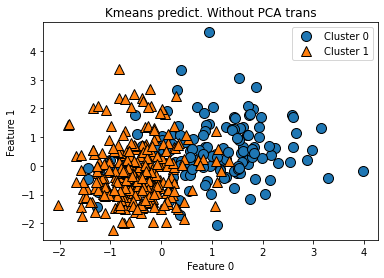

In [190]:
from sklearn.cluster import KMeans

# build the clustering model
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_train)
assignments=kmeans.labels_

mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], assignments)
plt.legend(["Cluster 0", "Cluster 1"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title("Kmeans predict. Without PCA trans")

Text(0.5, 1.0, 'Kmeans predict. PCA transformation')

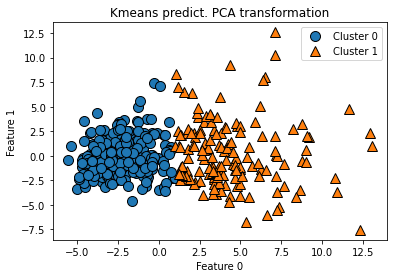

In [191]:
# build the clustering model
kmeans = KMeans(n_clusters=2)
kmeans.fit(X2_train)
assignments=kmeans.labels_

mglearn.discrete_scatter(X2_train[:, 0], X2_train[:, 1], assignments)
plt.legend(["Cluster 0", "Cluster 1"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title("Kmeans predict. PCA transformation")

## 4.3. Agglomerative / Hierarchical Clustering

Text(0.5, 1.0, 'AgglomerativeClustering Prediction. Without PCA.')

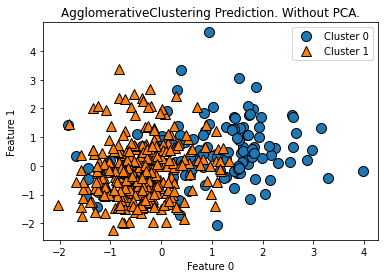

In [192]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=2)
assignment = agg.fit_predict(X_train)

mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], assignment)
plt.legend(["Cluster 0", "Cluster 1"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title("AgglomerativeClustering Prediction. Without PCA.")

Text(0.5, 1.0, 'AgglomerativeClustering Prediction. With PCA.')

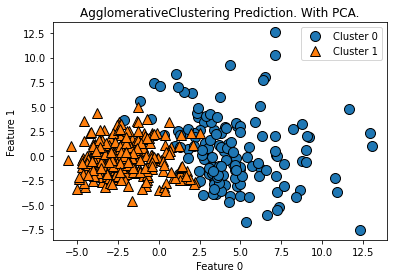

In [193]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=2)
assignment = agg.fit_predict(X2_train)

mglearn.discrete_scatter(X2_train[:, 0], X2_train[:, 1], assignment)
plt.legend(["Cluster 0", "Cluster 1"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
plt.title("AgglomerativeClustering Prediction. With PCA.")

Text(0.5, 1.0, 'Hierarchical Clustering Dendrogram. With PCA.')

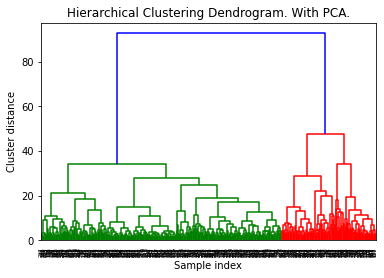

In [194]:
# Import the dendrogram function and the ward clustering function from SciPy
from scipy.cluster.hierarchy import dendrogram, ward

# Apply the ward clustering to the data array X
linkage_array = ward(X_train)
dendrogram(linkage_array)

# mark the cuts in the tree that signify two or three clusters
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")
plt.title("Hierarchical Clustering Dendrogram. With PCA.")

Text(0.5, 1.0, 'Hierarchical Clustering Dendrogram. With PCA.')

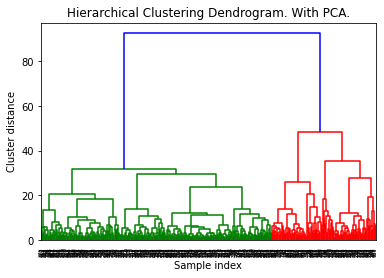

In [195]:
# Import the dendrogram function and the ward clustering function from SciPy
from scipy.cluster.hierarchy import dendrogram, ward

# Apply the ward clustering to the data array X
linkage_array = ward(X2_train)
dendrogram(linkage_array)

# mark the cuts in the tree that signify two or three clusters
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")
plt.title("Hierarchical Clustering Dendrogram. With PCA.")

## 4.3 DBSCAN

I couldn't produce a meaningful result using DBSCAN. 

Text(0, 0.5, 'Feature 1')

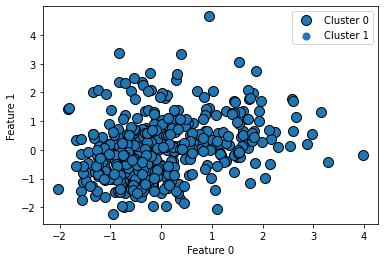

In [196]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(min_samples=10, eps=0.3) # Adjusting parameters didn't help much
clusters = dbscan.fit_predict(X_train)

# plot the cluster assignments
plt.scatter(X_train[:, 0], X_train[:, 1], c=clusters, cmap=mglearn.cm2, s=50)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], clusters)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [197]:
print(clusters)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

Text(0, 0.5, 'Feature 1')

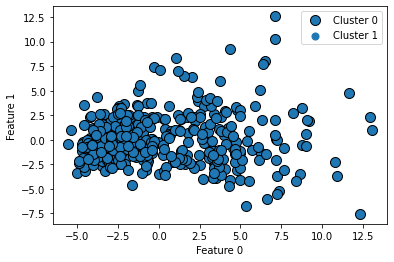

In [198]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(min_samples=2, eps=0.5)
clusters = dbscan.fit_predict(X2_train)

# plot the cluster assignments
plt.scatter(X2_train[:, 0], X2_train[:, 1], c=clusters, cmap=mglearn.cm2, s=50)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

mglearn.discrete_scatter(X2_train[:, 0], X2_train[:, 1], clusters)
plt.legend(["Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"], loc="best")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [199]:
print(clusters)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

## Step 4. ARI & Silhouette Coefficient for no PCA transformed data





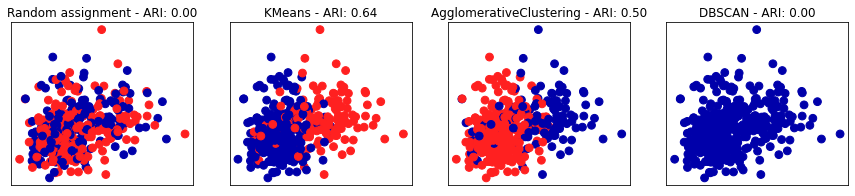

In [200]:
from sklearn.metrics.cluster import adjusted_rand_score

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# make a list of algorithms to use
algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2),
              DBSCAN()]

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X_train))

# plot random assignment
axes[0].scatter(X_train[:, 0], X_train[:, 1], c=random_clusters,
                cmap=mglearn.cm2, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(
        adjusted_rand_score(y_train, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    # plot the cluster assignments and cluster centers
    clusters = algorithm.fit_predict(X_train)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=clusters,
               cmap=mglearn.cm2, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__,
                                           adjusted_rand_score(y_train, clusters)))

ValueError: ignored

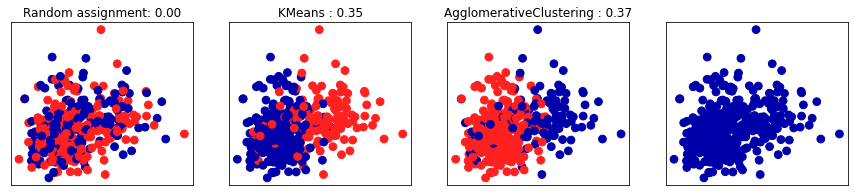

In [201]:
from sklearn.metrics.cluster import silhouette_score



fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X_train))

# plot random assignment
axes[0].scatter(X_train[:, 0], X_train[:, 1], c=random_clusters,
                cmap=mglearn.cm2, s=60)
axes[0].set_title("Random assignment: {:.2f}".format(
    silhouette_score(X_train, random_clusters)))

algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2),
              DBSCAN()]

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_train)
    # plot the cluster assignments and cluster centers
    ax.scatter(X_train[:, 0], X_train[:, 1], c=clusters, cmap=mglearn.cm2,
               s=60)
    ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__,
                                      silhouette_score(X_train, clusters))) # Error due to DBSCAN performance. Classification predicted only one class.

## Step 4. ARI & Silhouette Coefficient for PCA transformed data

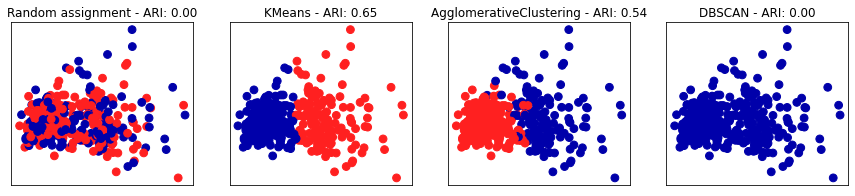

In [202]:
from sklearn.metrics.cluster import adjusted_rand_score

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# make a list of algorithms to use
algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2),
              DBSCAN()]

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X2_train))

# plot random assignment
axes[0].scatter(X2_train[:, 0], X2_train[:, 1], c=random_clusters,
                cmap=mglearn.cm2, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(
        adjusted_rand_score(y2_train, random_clusters)))

for ax, algorithm in zip(axes[1:], algorithms):
    # plot the cluster assignments and cluster centers
    clusters = algorithm.fit_predict(X2_train)
    ax.scatter(X2_train[:, 0], X2_train[:, 1], c=clusters,
               cmap=mglearn.cm2, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__,
                                           adjusted_rand_score(y2_train, clusters)))

ValueError: ignored

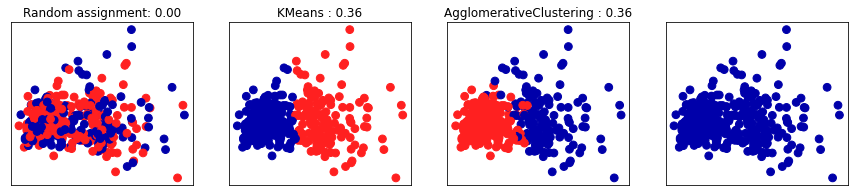

In [203]:
from sklearn.metrics.cluster import silhouette_score


fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X2_train))


# plot random assignment
axes[0].scatter(X2_train[:, 0], X2_train[:, 1], c=random_clusters,
                cmap=mglearn.cm2, s=60)
axes[0].set_title("Random assignment: {:.2f}".format(
    silhouette_score(X2_train, random_clusters)))

algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2),
              DBSCAN()]

for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X2_train)
    # plot the cluster assignments and cluster centers
    ax.scatter(X2_train[:, 0], X2_train[:, 1], c=clusters, cmap=mglearn.cm2,
               s=60)
    ax.set_title("{} : {:.2f}".format(algorithm.__class__.__name__,
                                      silhouette_score(X2_train, clusters))) # Error due to DBSCAN performance. Classification predicted only one class.